In [129]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


# Time Series Analysis: 
## Objective
- Data wranggling (outlier removal, price smoothing with low pass filters) 
- Autocorrelation Function (ACF)
- Correlation Analysis with CPI data from [Federal Reserve Economic Data (FRED)](https://fred.stlouisfed.org/)


In [156]:
listings = pd.read_csv('listings.csv')
listings['date_column'] = pd.to_datetime(listings['first_review'], format="%d/%m/%Y")
inflation = pd.read_excel('us_inflation.xlsx')
listings_df = listings[['id','price','date_column']].dropna(subset=['date_column'])
# listings.shape
# (3818, 53)
listings_df['price'] = listings_df['price'].str.replace(r'[^0-9.]', '', regex=True).astype(float)
listings_df

,id,price,date_column
0,241032,85.0,2011-11-01
1,953595,150.0,2013-08-19
2,3308979,975.0,2014-07-30
4,278830,450.0,2012-07-10
5,5956968,120.0,2015-06-11
...,...,...,...
3810,262764,154.0,2015-10-01
3811,8578490,65.0,2015-10-01
3812,3383329,95.0,2014-07-08
3813,8101950,359.0,2015-09-27


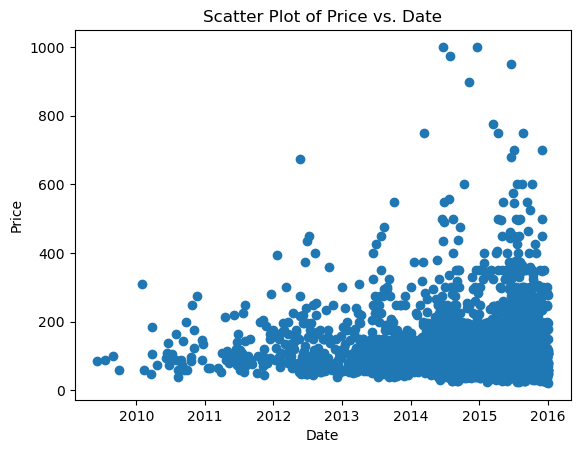

In [111]:
listings_df1 = listings_df.reset_index()
plt.scatter(listings_df1['date_column'], listings_df1['price'])

plt.title('Scatter Plot of Price vs. Date')

plt.xlabel('Date')
plt.ylabel('Price')

plt.show()

### Outlier Removal
Perform outlier removal based on Z-scores calculated and manually set threshold value of 3.0 and then visualizing the data using a scatter plot with NumPy and Matplotlib.

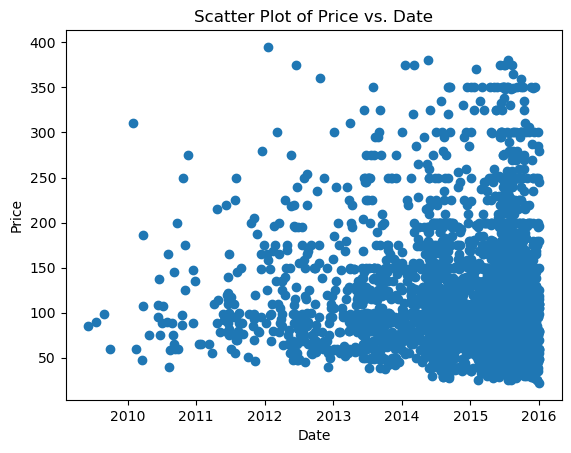

In [112]:
# remove outliers
z_scores = np.abs((listings_df['price'] - listings_df['price'].mean()) / listings_df['price'].std())

# threshold for outliers (3.0 - significant outlier)
threshold = 3.0

# remove outliers from the price column
df_without_outliers = listings_df[z_scores < threshold]

# visualize
df_without_outliers1 = df_without_outliers.reset_index()
plt.scatter(df_without_outliers1['date_column'], df_without_outliers1['price'])

plt.title('Scatter Plot of Price vs. Date')

plt.xlabel('Date')
plt.ylabel('Price')

plt.show()

### Remove High-Frequency Noise Or Fluctuations
Apply a low-pass filter to listing prices using the Butterworth filter from the SciPy library. The purpose of the low-pass filter is to smooth the time series data and remove high-frequency noise or fluctuations, while preserving the overall trend of the data.

This was chosen over the Moving Average approach for the following reasons:
1. The moving average method averages the data over a fixed window size. It doesn't offer precise control over the frequency response. While it can remove noise, the frequency response might not be as smooth as the Butterworth filter, and it may lead to some distortion in the underlying trend.
2. The Butterworth filter is designed to preserve the overall trend of the data while smoothing out noise. It achieves this by removing high-frequency noise while retaining low-frequency components, which represent the trend. On the other hand, the moving average can smooth the data and remove noise, but it might blur the underlying trend. For example, if the window size is too large, it can smooth out short-term fluctuations, potentially leading to a loss of trend details.



C:\Users\ASUS\AppData\Local\Temp\ipykernel_8804\2912249729.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_outliers['price_smoothed_low_pass_filters'] = scipy.signal.filtfilt(b, a, df_without_outliers['price'])


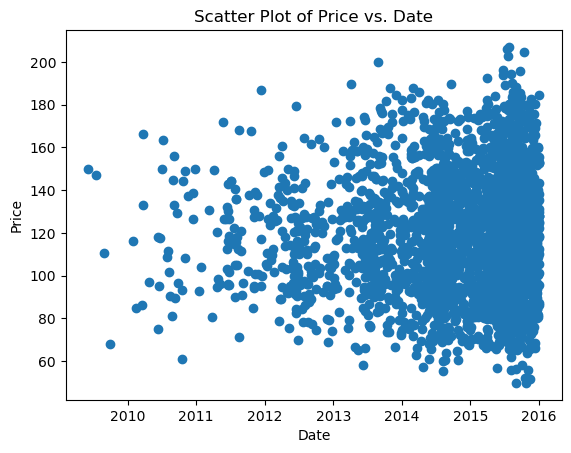

,date_column,id,price,price_smoothed,price_smoothed_low_pass_filters
0,2011-11-01,241032,85.0,NaN,85.082907
1,2013-08-19,953595,150.0,NaN,90.869712
2,2015-06-11,5956968,120.0,NaN,96.226814
3,2014-01-27,1909058,80.0,105.000000,101.042551
4,2013-01-03,856550,60.0,106.428571,105.260476
...,...,...,...,...,...
3124,2015-10-01,262764,154.0,153.857143,122.745824
3125,2015-10-01,8578490,65.0,149.571429,114.218086
3126,2014-07-08,3383329,95.0,NaN,104.189038
3127,2015-09-27,8101950,359.0,NaN,93.075922


In [115]:
import scipy.signal

cutoff_frequency = 0.1  # Adjust this value based on your data characteristics
b, a = scipy.signal.butter(4, cutoff_frequency)
df_without_outliers['price_smoothed_low_pass_filters'] = scipy.signal.filtfilt(b, a, df_without_outliers['price'])

# visualize
df_without_outliers1 = df_without_outliers.reset_index()
plt.scatter(df_without_outliers1['date_column'], df_without_outliers1['price_smoothed_low_pass_filters'])

plt.title('Scatter Plot of Price vs. Date')

plt.xlabel('Date')
plt.ylabel('Price')

plt.show()
df_without_outliers1

In [132]:
time_series = pd.Series(df_without_outliers['price_smoothed_low_pass_filters'], index=pd.to_datetime(df_without_outliers.index))
time_series

date_column
2011-11-01     85.082907
2013-08-19     90.869712
2015-06-11     96.226814
2014-01-27    101.042551
2013-01-03    105.260476
                 ...    
2015-10-01    122.745824
2015-10-01    114.218086
2014-07-08    104.189038
2015-09-27     93.075922
2015-12-18     81.378238
Name: price_smoothed_low_pass_filters, Length: 3129, dtype: float64

### Autocorrelation Function (ACF)
The ACF measures the correlation between a time series and its lagged versions (previous observations). It calculates how well the past values of a time series can predict its current value.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8804\2090726842.py:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(acf_values, use_line_collection=True)


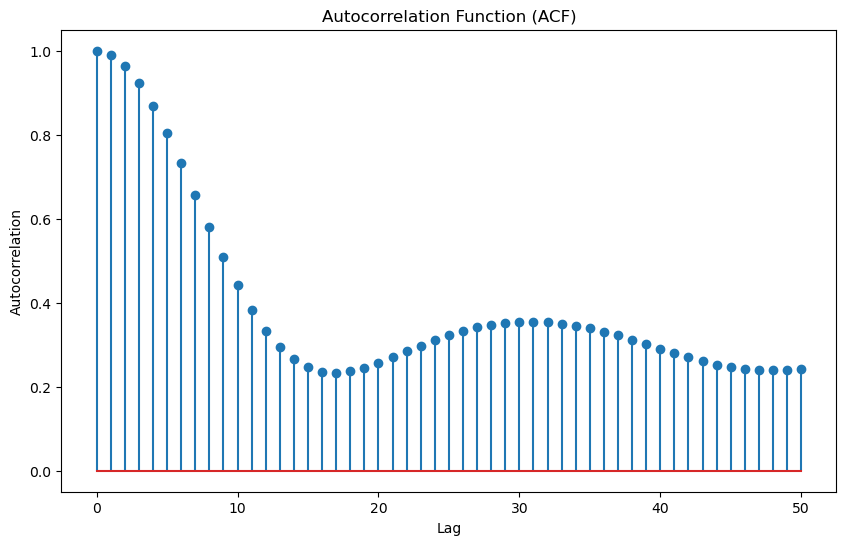

In [136]:
# Calculate the Autocorrelation Function (ACF)
acf_values = sm.tsa.acf(time_series, fft=True, nlags=50)

# Plot the ACF
plt.figure(figsize=(10, 6))
plt.stem(acf_values, use_line_collection=True)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function (ACF)")
plt.show()

The ACF plot does not show a clear peak at a lag that is a multiple of the seasonal period. This suggests that the Airbnb listing prices does not seem to have a strong seasonal component. It could be due to weak or irregular seasonality, noise, or other data characteristics.

However, the ACF plot does show a positive correlation between the prices at different lags. This suggests that the prices tend to be similar over time. This may be due to a number of factors, such as the fact that Airbnb listings are often priced based on the same factors, such as the location and amenities of the listing.

### Correlation Analysis
Examine the correlation between Airbnb listing prices and CPI data. Calculate the correlation coefficient to quantify the strength and direction of the relationship.

In [153]:
listings_df['year'] = listings_df['date_column'].dt.year
merged_df = listings_df.merge(inflation, on='year')
correlation_coefficient = merged_df['price'].corr(merged_df['cpi'])
print(f"Correlation coefficient between Airbnb listing prices and CPI data: {correlation_coefficient}")


Correlation coefficient between Airbnb listing prices and CPI data: 0.009861794181379615


The correlation coefficient is close to 0, which indicates a very weak linear relationship between Airbnb listing prices and CPI data. The small value suggests that changes in CPI data have little to no direct influence on Airbnb listing prices or vice versa.

That said, a correlation coefficient near 0 does not imply that there is no relationship between the variables; it simply means that the relationship is not well-explained by a linear model. There might be other complex relationships or factors at play that are not captured by the correlation coefficient alone.

### Data Wranggling to get Listings which have been booked for further analysis of reviews

In [4]:
calendar = pd.read_csv('calendar.csv')
calendar['date_column'] = pd.to_datetime(calendar['date'], format="%Y-%m-%d")
calendar = calendar[['listing_id','available','price','date_column']].dropna(subset=['date_column'])

In [189]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   listing_id   1393570 non-null  int64         
 1   available    1393570 non-null  object        
 2   price        1393570 non-null  float64       
 3   date_column  1393570 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 42.5+ MB


### How does the number of listings change depending on time of the year?

In [8]:
calendar['date_column'] = pd.to_datetime(calendar['date_column'])

# Extract the month from the 'date_column'
calendar['month'] = calendar['date_column'].dt.month

# Group the data by 'month' and 'available', then calculate the average for 'listing_id'
breakdown = calendar.groupby(['month', 'available'])['listing_id'].count().reset_index()
breakdown.rename(columns={'listing_id': 'count'}, inplace=True)

# Pivot the data to get a clearer view
breakdown_pivot = breakdown.pivot(index='month', columns='available', values='count')
breakdown_pivot.fillna(0, inplace=True)

# Calculate the average available and unavailable listings across months
breakdown_pivot['average_available_pct'] = breakdown_pivot['t'] / (breakdown_pivot['t'] + breakdown_pivot['f']) *100
breakdown_pivot['average_unavailable_pct'] = breakdown_pivot['f'] / (breakdown_pivot['t'] + breakdown_pivot['f']) *100

breakdown_pivot

available,f,t,average_available_pct,average_unavailable_pct
month,,,,
1,49603,64937,56.693731,43.306269
2,37401,73321,66.220805,33.779195
3,34420,83938,70.918738,29.081262
4,38503,76037,66.384669,33.615331
5,38387,79971,67.567042,32.432958
6,37296,77244,67.438449,32.561551
7,44136,74222,62.709745,37.290255
8,42011,76347,64.505145,35.494855
9,37294,77246,67.440196,32.559804


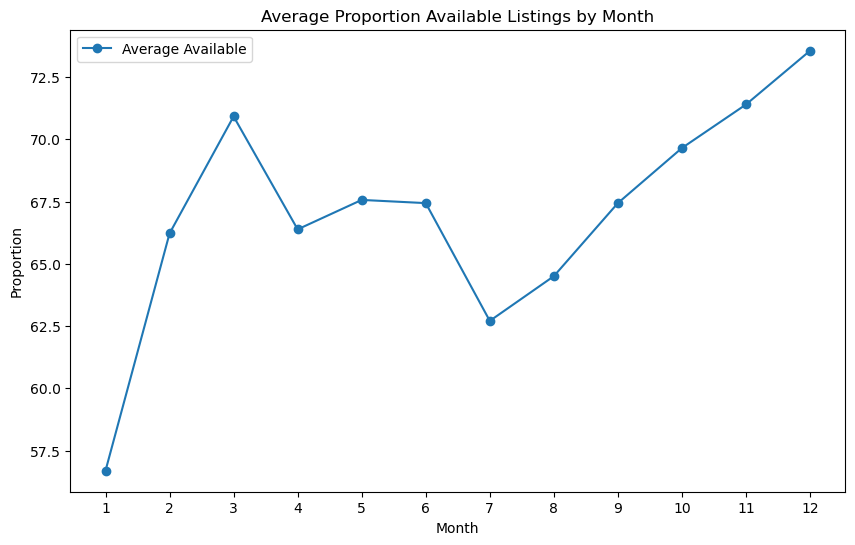

In [32]:
breakdown_df = breakdown_pivot.reset_index()
breakdown_df
plt.figure(figsize=(10, 6))
plt.plot(breakdown_pivot.index, breakdown_df['average_available_pct'], marker='o', label='Average Available')

plt.xlabel('Month')
plt.ylabel('Proportion')
plt.title('Average Proportion Available Listings by Month')
plt.xticks(breakdown_pivot.index)
plt.legend()

plt.show()


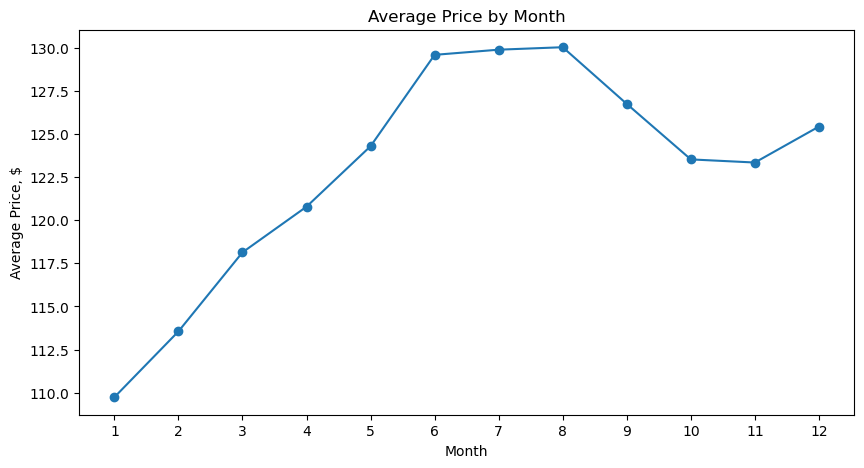

In [33]:
average_price_by_month = calendar.groupby(['month'])['price'].mean()

#plot
plt.figure(figsize=(10,5))
plt.plot(average_price_by_month, marker='o',)
plt.ylabel('Average Price, $')
plt.xlabel('Month')
plt.xticks(breakdown_pivot.index)
plt.title('Average Price by Month')

plt.show()


In [190]:
mask = (calendar['available'] == 'f') 
unavailable = calendar[mask]

In [194]:
unavailable.listing_id.nunique()

3140

In [192]:
unavailable.listing_id.value_counts()

listing_id
6226666     365
4557204     365
9699490     365
3793406     365
10339144    365
           ... 
4608208       1
3158210       1
3385421       1
10170744      1
4264012       1
Name: count, Length: 3140, dtype: int64

In [196]:
filtered_listing_df = listings[listings['id'].isin(unavailable['listing_id'])]
filtered_listing_df

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_id,host_name,...,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,cancellation_policy,calculated_host_listings_count,reviews_per_month,date_column
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,956883,Maija,...,71,346,4/1/2016,207,1/11/2011,2/1/2016,moderate,2,4.07,2011-11-01
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",5177328,Andrea,...,16,291,4/1/2016,43,19/8/2013,29/12/2015,strict,6,1.48,2013-08-19
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,16708587,Jill,...,17,220,4/1/2016,20,30/7/2014,3/9/2015,strict,2,1.15,2014-07-30
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,NaN,NaN,NaN,9851441,Emily,...,0,143,4/1/2016,0,NaN,NaN,flexible,1,NaN,NaT
5,5956968,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,If you include a bit of your background in you...,We're renting out a small private unit of one ...,This part of Queen Anne has wonderful views an...,Let me know if you need anything or have sugge...,The #1 and #2 bus picks up 2-3 blocks away (di...,326758,Andrew,...,27,302,4/1/2016,17,11/6/2015,28/9/2015,strict,1,2.45,2015-06-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,We're located near lots of family fun. Woodlan...,NaN,NaN,31148752,Bo,...,32,32,4/1/2016,1,27/9/2015,27/9/2015,strict,8,0.30,2015-09-27
3814,8902327,Portage Bay View!-One Bedroom Apt,800 square foot 1 bedroom basement apartment w...,This space has a great view of Portage Bay wit...,800 square foot 1 bedroom basement apartment w...,The neighborhood is a quiet oasis that is clos...,This is a basement apartment in a newer reside...,Uber and Car2go are good options in Seattle. T...,46566046,Glen,...,44,273,4/1/2016,2,18/12/2015,24/12/2015,moderate,1,2.00,2015-12-18
3815,10267360,Private apartment view of Lake WA,"Very comfortable lower unit. Quiet, charming m...",NaN,"Very comfortable lower unit. Quiet, charming m...",NaN,NaN,NaN,52791370,Virginia,...,88,88,4/1/2016,0,NaN,NaN,moderate,1,NaN,NaT
3816,9604740,Amazing View with Modern Comfort!,Cozy studio condo in the heart on Madison Park...,Fully furnished unit to accommodate most needs...,Cozy studio condo in the heart on Madison Park...,Madison Park offers a peaceful slow pace upsca...,NaN,Yes,25522052,Karen,...,90,179,4/1/2016,0,NaN,NaN,moderate,1,NaN,NaT
